<h2>This notebook provides a general implementation of multi-layer neural network</h2>
<h2>Aim of this notebook is to provide solutions to the A3-partb a, and b parts</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
def read_csv(filename):
    x = []
    y = []
    f = open(filename, 'r')
    for xx in f:
        l = xx.split(',')
        x.append([float(i)/255 for i in l[:784]])
        y.append(int(l[784]))
    return np.array(x), np.array(y)

In [3]:
train_x, train_y = read_csv('./Alphabets/train.csv')
test_x, test_y = read_csv('./Alphabets/test.csv')
# np.where(test_y == 1)[0] # returns list of indexes where alphabet in test data == 1

In [4]:
# Hyper-parameters
lr = 0.1
arch = [100]
mini_batch_size = 100
r = 26

><h3>Part a - Building Multilayer Neural Network</h3>

In [5]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-1*x))

class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

class Sigmoid(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
#         relu_forward = np.maximum(0,input)
        relu_forward = sigmoid(input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
#         print(input.shape)
        relu_grad = sigmoid(input) * (np.ones(shape=input.shape)-sigmoid(input))
        return grad_output*relu_grad

In [7]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [8]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [9]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
#     print([sigmoid(i) for i in logits])
    return logits.argmax(axis=-1)
#     return [sigmoid(i) for i in logits]

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

In [10]:
from tqdm import trange
from tqdm import tqdm as bae
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [11]:
# re = 2
# for i in bae(range(7000000)):
#     re += 1

In [12]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(test_y.reshape(-1, 1))
# test_y = enc.transform(test_y.reshape(-1,1)).toarray()
# train_y = enc.transform(train_y.reshape(-1,1)).toarray()

In [13]:
X_train, X_val = train_x[:-3000], train_x[-3000:]
y_train, y_val = train_y[:-3000], train_y[-3000:]
X_test, y_test = test_x, test_y

In [14]:
# enc.inverse_transform(y_train).reshape(-1)[i]

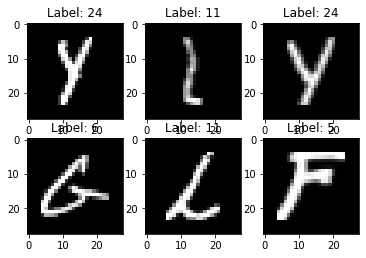

In [15]:
## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(3,9):
    plt.subplot(3,3,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [24]:
network = []
prev = train_x.shape[1]
for i in range(len(arch)):
    network.append(Dense(prev, arch[i]))
    network.append(Sigmoid())
    prev = arch[i]
network.append(Dense(100, r))
# network.append(Dense(train_x.shape[1], 100))

In [25]:
from IPython.display import clear_output
train_log = []
val_log = []
test_log = []

Epoch 29
Train accuracy: 0.9776
Val accuracy: 0.9016666666666666
Test accuracy:  0.8944615384615384


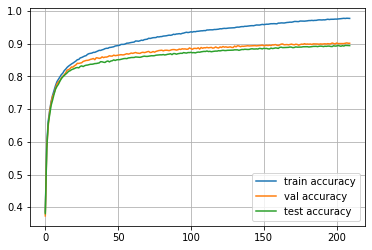

In [32]:
for epoch in range(30):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=mini_batch_size,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    test_log.append(np.mean(predict(network, X_test)==y_test))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    print("Test accuracy: ", test_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.plot(test_log, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

<h5>Result of part-a</h5>
Epoch 210<br>
Train accuracy: 0.9776<br>
Val accuracy: 0.9016666666666666<br>
Test accuracy:  0.8944615384615384<br>

><h3>Part b - Varying single hidden layer size</h3>

In [33]:
hyperparams = {'arch': [100], 'r': 26, 'lr': 0.1, 'mini_batch_size': 100}

def run_nnet(hyperparams):
    network = []
    prev = train_x.shape[1]
    for i in range(len(hyperparams['arch'])):
        network.append(Dense(prev, hyperparams['arch'][i]))
        network.append(Sigmoid())
        prev = hyperparams['arch'][i]
    network.append(Dense(prev, hyperparams['r']))
    
    train_log = []
    val_log = []
    test_log = []
    
    for epoch in range(210):
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=hyperparams['mini_batch_size'],shuffle=True):
            train(network,x_batch,y_batch)

        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))
        test_log.append(np.mean(predict(network, X_test)==y_test))

        clear_output()
        print("Epoch",epoch)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
        print("Test accuracy: ", test_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.plot(test_log, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig('./results/b/'+str(hyperparams['arch'][0])+'_layer_size.png')
    plt.clf()
    
    return train_log[-1], test_log[-1]

In [34]:
archlist = [1, 5, 10, 50, 100]
yy_train = []
yy_test = []
time_l = []
for i in (archlist):
    hyperparams['arch'] = [i]
    start = time.time()
    train_acc, test_acc = run_nnet(hyperparams)
    yy_train.append(train_acc)
    yy_test.append(test_acc)
    time_l.append(time.time()-start)

plt.plot(archlist, yy_train, label = 'training acc')
plt.plot(archlist, yy_test, label = 'testing acc')
plt.legend(loc='best')
plt.grid()
plt.savefig('./results/b/'+'acc_vs_layer_size'+'.png')
plt.clf()

Epoch 209
Train accuracy: 0.9795
Val accuracy: 0.9033333333333333
Test accuracy:  0.8916923076923077


<Figure size 432x288 with 0 Axes>

In [35]:
print('Layer size vs exec. time:')
for i in range(len(archlist)):
    print('For layer size = %d, time for exec = %s' % (archlist[i], str(time_l[i])))

Layer size vs exec. time:
For layer size = 1, time for exec = 34.785210847854614
For layer size = 5, time for exec = 44.69850492477417
For layer size = 10, time for exec = 40.39457678794861
For layer size = 50, time for exec = 61.562925815582275
For layer size = 100, time for exec = 102.44993090629578


<center>Layer size vs exec. time (30 epochs with ReLU):</center>

|Layer Size|Exec Time (sec)|
|----------|---------|
1|4.735213756561279<br>
5|6.814701080322266<br>
10|7.745318174362183<br>
50|11.847243070602417<br>
100|14.13257098197937

<center>Layer size vs exec. time [210 epochs with Sigmoid]:</center>

|Layer Size|Exec Time (sec)|Train Accuracy|Test Accuracy|
|----------|---------|--------------|-------------|
1 |34.785210847854614 |0.1172|0.11523076923076923|
5 |44.69850492477417 |0.673|0.6187692307692307|
10 |40.39457678794861 |0.8455|0.7761538461538462|
50 |61.562925815582275 |0.9665|0.8792307692307693|
100 |102.44993090629578 |0.9795|0.8916923076923077|